<a href="https://colab.research.google.com/github/ttya16/kaggle_LANL_Earthquake_Prediction/blob/master/Kaggle_LANL_Earthquake_prediction_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle "LANL-Earthquake-Prediction" approach by Tnb
**[Competition top page](https://www.kaggle.com/c/LANL-Earthquake-Prediction)**


Author:<br>
[Tnb(me)](https://www.kaggle.com/ttya16)


Team:<br>
[kambarakun](https://www.kaggle.com/kambarakun)<br>
[ktok](https://www.kaggle.com/yutoktok)<br>
[nishiken](https://www.kaggle.com/knishi)

## Settings and some installs beforehand
* Notebook setting: Follow Edit > Notebook settings and select GPU as a hardware accelerator.

In [0]:
!pip install kaggle
!pip install numpy==1.16.0
!pip install tsfresh

In [1]:
#upload kaggle.json
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#make sure kaggle is installed correctly
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3115           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11012            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4666           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         38           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3373           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [3]:
#download the Earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 59.1MB/s]
 98% 236M/242M [00:01<00:00, 139MB/s]
100% 242M/242M [00:01<00:00, 172MB/s]
 99% 2.01G/2.03G [00:17<00:00, 140MB/s]
100% 2.03G/2.03G [00:17<00:00, 123MB/s]


In [4]:
#unzip train dataset
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


## The goal for this competition

* Predict the final TTF of each test segment which consists of 150000 acoustic signal data.

* Evaluation :MAE(mean absolute error); so you have to minimize this score.
$$
MAE = \frac{\sum_{i=1}^{n}{|y_i - \hat{y_i}|}}{n}
$$

In [0]:
#import libraries for EDA
import numpy as np
import pandas as pd
import tsfresh.feature_extraction.feature_calculators as fc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#load train data
%%time
train_df = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
data_len = len(train_df)

CPU times: user 2min 25s, sys: 39.4 s, total: 3min 5s
Wall time: 3min 14s


In [20]:
print(train_df.shape)
train_df.head()

(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


train data size = (629145480, 2)   
* **acoustic_data**(the sequence of int values which indicate the size of the quake, measured by some equipment in the earthquake lab.)
* **time_to_failure"**(the amount of time(seconds) left until the next earthquake event.)


Now let's plot the data and see how they behave.
(Since the dataset is pretty huge, I'm just going to plot the first 7500000 data.)



Text(0.5, 1.0, 'Acoustic Data and TTF over time.')

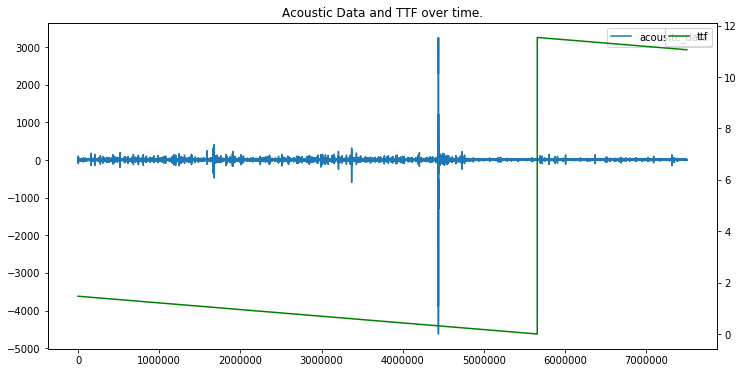

In [9]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
plt.plot(train_df["acoustic_data"][:7500000], label="acousitc_data")
ax1.legend()
ax2 = ax1.twinx()
plt.plot(train_df["time_to_failure"][:7500000], color="g", label="ttf")
ax2.legend()
plt.title("Acoustic Data and TTF over time.")

### What can be seen from plotting the dataset.

* acoustic_data: Contiuously oscillating most of the time and abruptly making a huge oscillation when an earthquake(-like event) occurs.<br>
If you look closely enough, there are slight differences in patterns between before and after the earthquake.


* time_to_failure: Constantly decreasing until the earthquake event. When an earthquake occurs(observed very large acoustic signal), it calculates the next ttf and overwrites itself a bit after the earthquake event.

* Not shown here but if you plot the whole train data, they include 16 earthquake events in total.

In [11]:
train_df["acoustic_data"][:7500000].describe()

count    7.500000e+06
mean     4.511330e+00
std      2.043296e+01
min     -4.621000e+03
25%      2.000000e+00
50%      4.000000e+00
75%      7.000000e+00
max      3.252000e+03
Name: acoustic_data, dtype: float64

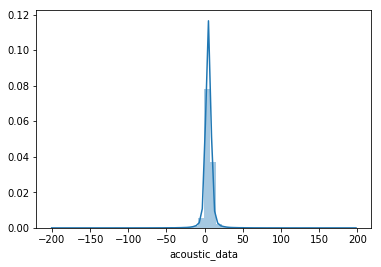

In [16]:
sns.distplot(a=train_df["acoustic_data"][:750000], kde=True)

From the distplot of the first 750000 data above, you might wanna guess that the distribution of the data are slightly skew in positive direction?

In [21]:
train_df["acoustic_data"].mean()

4.519467573700124

The average value of the acoustic_data is about 4.52, which implies that the whole data are skew as guessed above.

### Source of the dataset
Kaggle's Discussion [Introduction](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77525), [Additional Info](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526)

Quotes from the competition organizers:<br>
*The data for this challenge comes from a classic laboratory earthquake experiment, that has been studied in depth as a tabletop analog of seismogenic faults for decades. A number of physical laws widely used by the geoscience community have been derived from this earthquake machine.*

* The datasets are from the measurements of the earthquake laboratory (not real earthquakes of course).
* The data are recorded in bins of 4096 samples. Withing those bins seismic data are recorded at 4MHz, but there is a 12 microseconds gap between each bin, an artifact of the recording device.

41
0.0000001192seconds gap.
149
0.0000001192seconds gap.
258
0.0000001192seconds gap.
366
0.0000001192seconds gap.
474
0.0000001192seconds gap.
583
0.0000001192seconds gap.
691
0.0000001192seconds gap.
799
0.0000001192seconds gap.
908
0.0000001192seconds gap.
1016
0.0000001192seconds gap.
1125
0.0000001192seconds gap.
1233
0.0000001192seconds gap.
1341
0.0000001192seconds gap.
1450
0.0000001192seconds gap.
1558
0.0000001192seconds gap.
1666
0.0000001192seconds gap.
1775
0.0000001192seconds gap.
1883
0.0000001192seconds gap.
1991
0.0000001192seconds gap.
2100
0.0000001192seconds gap.
2208
0.0000001192seconds gap.
2317
0.0000001192seconds gap.
2425
0.0000001192seconds gap.
2533
0.0000001192seconds gap.
2642
0.0000001192seconds gap.
2750
0.0000001192seconds gap.
2858
0.0000001192seconds gap.
2967
0.0000001192seconds gap.
3075
0.0000001192seconds gap.
3184
0.0000001192seconds gap.
3292
0.0000001192seconds gap.
3400
0.0000001192seconds gap.
3509
0.0000001192seconds gap.
3617
0.0000001192sec

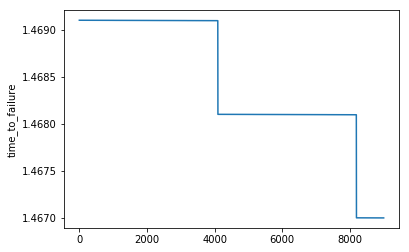

In [22]:
ttf_small=train_df["time_to_failure"][:9000]

for i, ttf in enumerate(ttf_small[:5000]):
  if i == 0: continue
  if ttf_small[i-1] != ttf:
    print(i)
    print("{:.10f}seconds gap.".format(ttf_small[i-1] - ttf))
sns.lineplot(x=ttf_small.index, y=ttf_small)

From the plot above, you can see that there are about 0.12 microseconds of gap every 108~110 data, and a rather big gap of 1 ms every 4095 data.<br>
Compared to the information given from the organizers, it seems that we are not provided with enough details about how data are measured and created.<br>


Our team tried to divide the acoustic data into 4096 so as to see the difference of the measurements of each censor. But it turned out that it is very difficult to precisely allocate every data since the gaps in the whole data are quite random. So we decided not to go deeper into this topic any more.

In [0]:
del train_df

## Approach

* Since each test data consist of 150000 acoustic signals, you have to split train data into the same length.

* For each segment, calculate some statistical features.

* After these process, you get a matrix of n(number of segments) $\times$ m(number of features) as below.


$$
    \boldsymbol{
        \begin{array}{c|ccc}
            {} & Feat_1 & \cdots & Feat_m \\
            seg_1 & \hline \\
             \vdots & \vdots  & \vdots & \vdots \\
             seg_n & {} & {} & {} \\
        \end{array}}
$$

* Define and train a model with this data.

### The key point of this prediction.
The most important factor of this feature engineering is to find one that helps much for predicting when an earthquake occurs and how big the next one will likely be.<br>
Compare how two very basic statsitical feature "mean" and "std" changes over time.

In [0]:
def gen_features_test(X):
  strain = pd.Series()
  X_len = len(X)
  
  strain["mean"] = X.mean()
  strain["std"] = X.std()
  
  return strain

In [27]:
chunksize = 150000
data_len = 629145480
train = pd.read_csv("train.csv", iterator=True, chunksize=chunksize, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
df = pd.DataFrame()
c = 0
print("Start preprocessing...")
for chunk in train:
  c += 1
  df = df.append(chunk)
  if len(df) >= chunksize:
    df = df[-chunksize:]
    ch = gen_features_test(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    preprocessed_portion = (X_train.shape[0]*chunksize*100)/data_len
    if c % 100 == 0:
      print("\r" + str(round(preprocessed_portion, 1)) + "% done." + "="*int(preprocessed_portion/10)+">" + " "*(10- int(preprocessed_portion/10))+"||", end="")
      
print("\r" + "100% done." + "="*10 + ">"+ "||", end="")

Start preprocessing...
100% done.==========>||

In [0]:
#scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

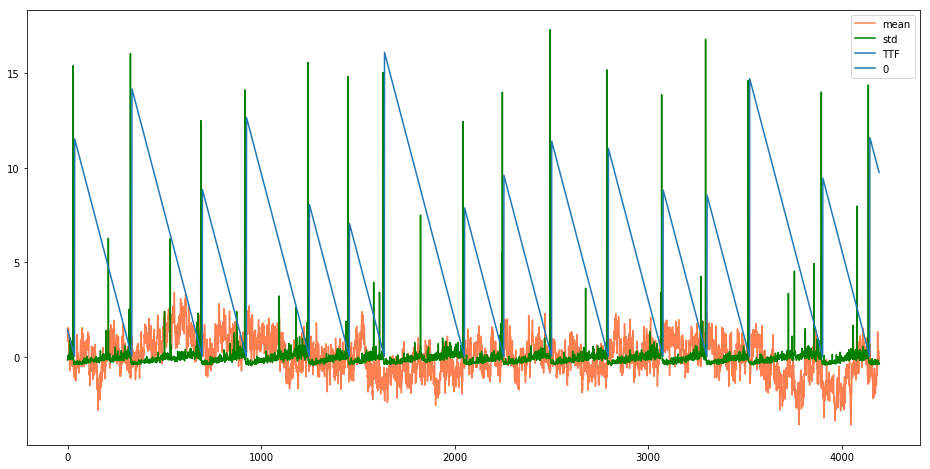

In [47]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.lineplot(data=X_train_sc[:,0], dashes=False, color='coral', label='mean')
sns.lineplot(data=X_train_sc[:,1], dashes=False, color='green', label='std')
sns.lineplot(data=np.array(y_train).reshape(4195, 1), label='TTF')

As shown above, value of "mean" does not seem to have a strong correlation with TTF.<br>
If you look at "std" though, you can see that they are gradually getting stronger sign as they approache the earthquake event, where TTF becomes zero.


From these point of view, you may conclude that the feature "std" seems much more useful than "mean" in predicting the earthquake event.

### Our team's approach
1. Create and choose as many features as possible even though they have little correlation with the TTF. And then put it into the LightGBM model and train it.<br>
Since the LightGBM model automatically learns to choose the optimal features during training, so many features won't necessarily lead to poor accuracy.
<br>
We applied basic statistical features from kernels below and our originally selected and created features.<br>
We created a simple AutoEncoder model that aims to generate the same acoustic data and extracted outputs from the encoder layer (which were 8 outputs in our case) and used them as our original feature.<br>

 [Andrew kernel](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples), [Scirpus kernel](https://www.kaggle.com/scirpus/gp-teeny-tiny)
 
For the AutoEncoder model, I was working in the Kaggle kernel linked below.

[LANL_Earthquake_AE_features](https://www.kaggle.com/ttya16/lanl-earthquake-ae-features)


**For this approach, the overall feature engineering and model designing was done by one of my teammate's local machine so I cannot share them here. :(**


2. Selected only three features that seem to have high correlation.
Then create a RNN model and train with it.

Since it is crucial to precisely predict the scale of an earthquake from the information from past, I expected that the RNN model is going to perform well on this problem.





In [0]:
#Feature generator function for RNN model
def gen_features_nn(X):
  strain = pd.Series()
  X_len = len(X)
  
  strain["num_peaks10"] = fc.number_peaks(X, 10)
  strain["new_std"] = X[np.logical_and(0<=X,X<=10)].std()
  strain["auto_correlation"] = fc.autocorrelation(X, 10)
  #strain["iqr"] = np.subtract(*np.percentile(X, [75, 25]))
  #strain["std"] = X.std()
  
  return strain

In [7]:
#Create feature matrix from train data
chunksize = 150000
data_len = 629145480
train = pd.read_csv("train.csv", iterator=True, chunksize=chunksize, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
df = pd.DataFrame()
c = 0
print("Start preprocessing...")
for chunk in train:
  c += 1
  df = df.append(chunk)
  if len(df) >= chunksize:
    df = df[-chunksize:]
    ch = gen_features_nn(df['acoustic_data'])
    #ch = gen_features_nn(np.sign(df['acoustic_data'])*np.log1p(abs(df['acoustic_data'])))
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    preprocessed_portion = (X_train.shape[0]*chunksize*100)/data_len
    if c % 100 == 0:
      print("\r" + str(round(preprocessed_portion, 1)) + "% done." + "="*int(preprocessed_portion/10)+">" + " "*(10- int(preprocessed_portion/10))+"||", end="")
      
print("\r" + "100% done." + "="*10 + ">"+ "||", end="")

Start preprocessing...
100% done.==========>||

In [8]:
print(X_train.shape)
X_train.head()

(4195, 3)


,auto_correlation,new_std,num_peaks10
0,-0.469692,2.612762,5470.0
1,-0.450367,2.603993,5474.0
2,-0.480152,2.642996,5549.0
3,-0.374296,2.623487,5458.0
4,-0.385905,2.613405,5381.0


In [9]:
print(y_train.shape)
y_train.head()

(4195,)


0    1.430797
0    1.391499
0    1.353196
0    1.313798
0    1.274400
dtype: float64

In [10]:
#Check how much each feature is correlated with the y(TTF) value
np.abs(X_train.corrwith(pd.Series(y_train.values))).sort_values(ascending=False).head()

new_std             0.677028
num_peaks10         0.638695
auto_correlation    0.441112
dtype: float64

## Creating and Training RNN model

In [12]:
#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

#split into training data and validation data
from sklearn.model_selection import train_test_split

X_tr_sc, X_val_sc, y_tr_sc, y_val_sc = train_test_split(X_train_sc, y_train, test_size=0.1,shuffle=False)

print(X_tr_sc.shape)
print(y_tr_sc.shape)
print(X_val_sc.shape)
print(y_val_sc.shape)

#reshape for putting into RNN model
X_tr_reshaped = np.reshape(np.array(X_tr_sc), (X_tr_sc.shape[0], 1, X_tr_sc.shape[1]))
X_val_reshaped = np.reshape(np.array(X_val_sc), (X_val_sc.shape[0], 1, X_val_sc.shape[1]))

print(X_tr_reshaped.shape)
print(X_val_reshaped.shape)

(3775, 3)
(3775,)
(420, 3)
(420,)
(3775, 1, 3)
(420, 1, 3)


In [14]:
#import some from keras to create the model
from keras.models import Sequential
from keras.layers import Dense, GRU, CuDNNLSTM, CuDNNGRU, Dropout, BatchNormalization, Bidirectional

Using TensorFlow backend.


### LSTM model
* Used CuDNNLSTM layer for faster processing.

In [15]:
n_features = X_tr_sc.shape[1]

#LSTM model

#Adding more layers didn't make the performace improve much.


model_lstm = Sequential()
model_lstm.add(CuDNNLSTM(128, return_sequences = True, input_shape=(None, n_features)))
model_lstm.add(CuDNNLSTM(128, return_sequences = True))
model_lstm.add(Dropout(0.2))
model_lstm.add(CuDNNLSTM(64, return_sequences = True))
model_lstm.add(Dropout(0.2))
model_lstm.add(CuDNNLSTM(64, return_sequences = True))
model_lstm.add(Dropout(0.2))
#model_lstm.add(CuDNNLSTM(64, return_sequences = True))
#model_lstm.add(Dropout(0.2))
#model_lstm.add(CuDNNLSTM(32, return_sequences = True))
#model_lstm.add(Dropout(0.2))
model_lstm.add(CuDNNLSTM(32))
model_lstm.add(Dense(10, activation='relu'))
#model_lstm.add(BatchNormalization())
#model.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 128)         68096     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, None, 128)         132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, None, 64)          49664     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLS

In [16]:
#compile & train bidirectional RNN model
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

#ModelCheckpoint
modelCheckpoint = ModelCheckpoint(filepath = 'model_lstm.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)


model_lstm.compile(optimizer = adam(lr=0.005), loss='MAE')
model_lstm.fit(X_tr_reshaped, y_tr_sc, 
               epochs=50, 
               batch_size=100, 
               verbose=1,
               validation_split=0.1,
               callbacks = [modelCheckpoint])

Instructions for updating:
Use tf.cast instead.
Train on 3397 samples, validate on 378 samples
Epoch 1/50
3397/3397 [==============================] - 7s 2ms/step - loss: 3.5913 - val_loss: 3.3957

Epoch 00001: val_loss improved from inf to 3.39570, saving model to model_lstm.h5
Epoch 2/50
3397/3397 [==============================] - 0s 89us/step - loss: 2.0421 - val_loss: 3.4284

Epoch 00002: val_loss did not improve from 3.39570
Epoch 3/50
3397/3397 [==============================] - 0s 94us/step - loss: 2.0119 - val_loss: 3.3023

Epoch 00003: val_loss improved from 3.39570 to 3.30229, saving model to model_lstm.h5
Epoch 4/50
3397/3397 [==============================] - 0s 89us/step - loss: 1.9908 - val_loss: 3.2650

Epoch 00004: val_loss improved from 3.30229 to 3.26502, saving model to model_lstm.h5
Epoch 5/50
3397/3397 [==============================] - 0s 90us/step - loss: 1.9908 - val_loss: 3.5735

Epoch 00005: val_loss did not improve from 3.26502
Epoch 6/50
3397/3397 [========

LSTM 1.4886895175812342


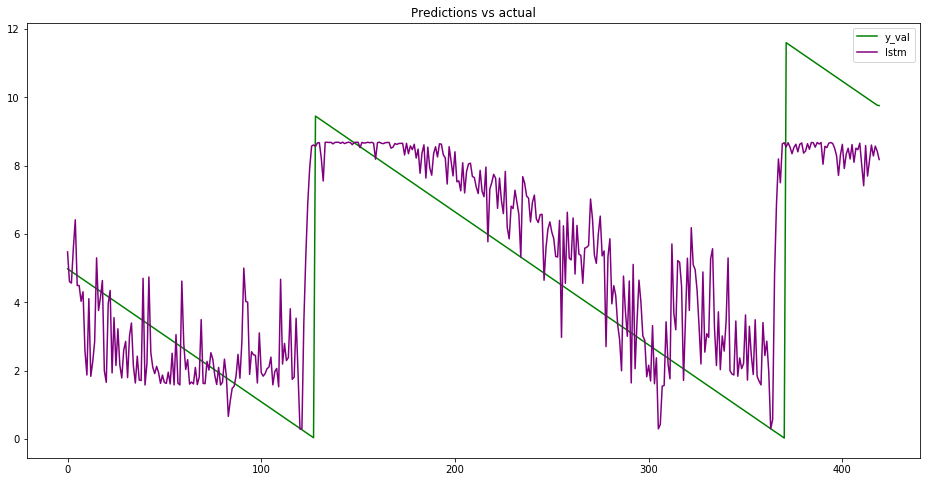

In [17]:
#plot the validation data and the model's prediction
from sklearn.metrics import mean_absolute_error
X_val_reshaped = np.reshape(np.array(X_val_sc), (X_val_sc.shape[0], 1, X_val_sc.shape[1]))



y_pred_lstm = model_lstm.predict(X_val_reshaped)
val_error_lstm = mean_absolute_error(y_val_sc, y_pred_lstm)
print("LSTM", val_error_lstm)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(np.array(y_val_sc), color='g', label='y_val')
plt.plot(y_pred_lstm, color='purple', label='lstm')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

In [19]:
y_pred_lstm.max()

8.688811

* Prediction from the LSTM model is somehow clipping the signals at the value of 8.688811.(probably thanks to the tanh function inside the LSTM layer?)

* Training and cross-val errors are not really good but validation error is pretty low. 

### GRU model
* Used CuDNNGRU layer for faster processing.

In [20]:
#GRU

model_gru = Sequential()
model_gru.add(CuDNNGRU(128, return_sequences = True, input_shape=(None, n_features)))
model_gru.add(CuDNNGRU(128, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(CuDNNGRU(64, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(CuDNNGRU(64, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(CuDNNGRU(32))
#model_gru.add(Dropout(0.3))
model_gru.add(Dense(10, activation='relu'))
#model_gru.add(BatchNormalization())
#model.add(Dropout(0.2))
model_gru.add(Dense(1))

model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         51072     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 64)          37248     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, None, 64)          24960     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 64)          0         
__________

In [21]:
#compile & train RNN model
from keras.optimizers import adam

#ModelCheckpoint
modelCheckpoint_2 = ModelCheckpoint(filepath = 'model_gru.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)


model_gru.compile(optimizer = adam(lr=0.005), loss='MAE')
model_gru.fit(X_tr_reshaped, y_tr_sc, epochs=50, batch_size=100, verbose=1, validation_split=0.1, callbacks=[modelCheckpoint_2])

Train on 3397 samples, validate on 378 samples
Epoch 1/50
3397/3397 [==============================] - 1s 416us/step - loss: 3.0939 - val_loss: 3.3430

Epoch 00001: val_loss improved from inf to 3.34298, saving model to model_gru.h5
Epoch 2/50
3397/3397 [==============================] - 0s 88us/step - loss: 2.0519 - val_loss: 3.3023

Epoch 00002: val_loss improved from 3.34298 to 3.30231, saving model to model_gru.h5
Epoch 3/50
3397/3397 [==============================] - 0s 87us/step - loss: 2.0091 - val_loss: 3.5279

Epoch 00003: val_loss did not improve from 3.30231
Epoch 4/50
3397/3397 [==============================] - 0s 90us/step - loss: 2.0134 - val_loss: 3.2694

Epoch 00004: val_loss improved from 3.30231 to 3.26944, saving model to model_gru.h5
Epoch 5/50
3397/3397 [==============================] - 0s 86us/step - loss: 2.0127 - val_loss: 3.4672

Epoch 00005: val_loss did not improve from 3.26944
Epoch 6/50
3397/3397 [==============================] - 0s 87us/step - loss: 2.

(420, 1, 3)
GRU 1.4230959424658534


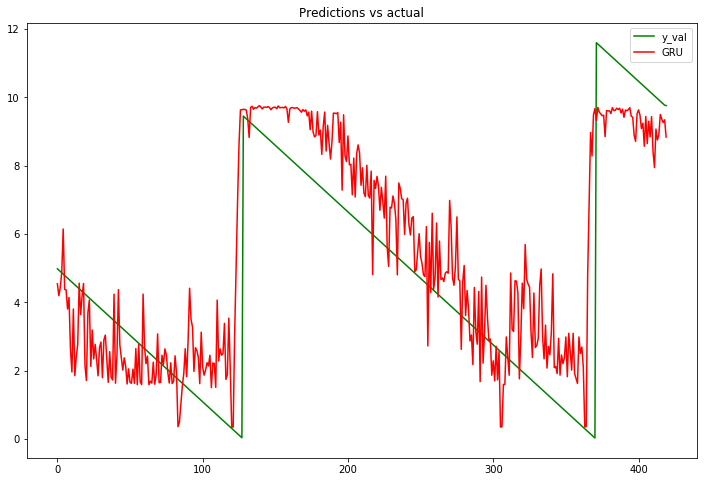

In [22]:
from sklearn.metrics import mean_absolute_error
X_val_reshaped = np.reshape(np.array(X_val_sc), (X_val_sc.shape[0], 1, X_val_sc.shape[1]))
print(X_val_reshaped.shape)
y_pred_gru = model_gru.predict(X_val_reshaped)
val_error_gru = mean_absolute_error(y_val_sc, y_pred_gru)
print("GRU", val_error_gru)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(np.array(y_val_sc), color='g', label='y_val')
plt.plot(y_pred_gru, color='r', label='GRU')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

In [23]:
y_pred_gru.max()

9.758987

* For GPU model, it's clipping the output at the value of 9.758987.

Both LSTM and GRU models are learning to lop out the data but in a bit different scales.<br>
So I took their average and adopted as my submission output.

LSTM 1.4886895175812342
GRU 1.4230959424658534
MEAN 1.4402162890314039


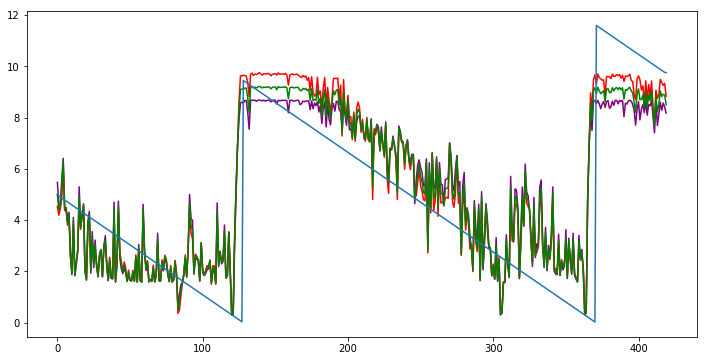

In [24]:
print("LSTM", val_error_lstm)
print("GRU", val_error_gru)
print("MEAN", mean_absolute_error(y_val_sc, (y_pred_lstm+y_pred_gru)/2))
#print("Neural Network", val_error_simplenn)

plt.figure(figsize=(12,6))
plt.plot(y_pred_lstm, color='purple', label='lstm')
plt.plot(y_pred_gru, color='red', label='gru')
plt.plot((y_pred_lstm+y_pred_gru)/2, color="green", label='mean')
plt.plot(np.array(y_val_sc))
#plt.plot(y_pred_simplenn, color='blue', label='NN')


plt.show()



## Considerations
* Each model succeeds in learning that the TTF increases rapidly after an earthquake and gradually decreases until the next quake.

* Lopping out the signal seems to be working fine when the model mis-predicting in a larger way.

The codes below are for creating a submission file.

In [0]:
# for submission
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()
X_test_max={}

for seg_id in submission.index:
    seg = pd.read_csv(seg_id + '.csv')
    #ch = gen_features_nn(np.sign(seg['acoustic_data'])*np.log1p(abs(seg['acoustic_data'])))
    ch = gen_features_nn(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

X_test_sc = sc.fit_transform(X_test)
print(X_test.shape)

In [0]:
X_test_reshaped = np.reshape(np.array(X_test_sc), (X_test.shape[0], 1, X_test.shape[1]))
pred_lstm = model_lstm.predict(X_test_reshaped)
pred_gru = model_gru.predict(X_test_reshaped)

pred_blend =pred_blend_min = np.stack([np.reshape(pred_lstm, (pred_lstm.shape[0],)), np.reshape(pred_gru, (pred_gru.shape[0],))], axis=1).mean(axis=1)

pred_final = abs(pred_lstm)#Prediction should not include negative values.(TTF > 0)

#Checkin the distribution of the prediction results for the test data.
plt.figure(figsize=(8, 4))
plt.hist(pred_final, bins=100)

pd.DataFrame(pred_final).describe()

In [0]:
submission['time_to_failure'] = pred_final
submission.to_csv('submission_rnnfinal.csv')